## ML Approaches for classification of target DBE 

### Second approach drop prime vend and treat bid days as categorical variable

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import RareLabelEncoder, MeanEncoder,OneHotEncoder,OrdinalEncoder
from feature_engine.discretisation import DecisionTreeDiscretiser
from feature_engine.imputation import (
AddMissingIndicator,
MeanMedianImputer,
CategoricalImputer,
 )   
%matplotlib inline
SEED = 42

In [2]:
#options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.options.display.float_format = '{:.0f}'.format

In [3]:
data = pd.read_csv("multi_row_per_sample.csv") #Read the dataset

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2,3,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = data.drop('Unnamed: 0', 1)

In [5]:
data.drop(data.iloc[:, 47:216], inplace=True, axis=1)

In [6]:
data = data.drop('LN_ITM_NBR', 1)
data = data.drop('PRD_END_DT', 1)
data = data.drop('EST_T', 1)
data = data.drop('current_item_payment_amount', 1)
data = data.drop('payments_cumsum', 1)
data = data.drop('Bin 1 (%)', 1)
data = data.drop('Bin 171 (%)', 1)

In [7]:
data = data.drop_duplicates()

In [8]:
data.reset_index(drop=True, inplace=True)

In [9]:
data = data.drop('TOTAL_PD', 1)
data = data.drop('TOT_VERF_PAYM_AMT', 1)
data = data.drop('DBE_PAYSUM', 1)
data = data.drop('Subcontract_appr_date', 1)
data = data.drop('Subcontract_payment_date', 1)
data = data.drop('subcontract_payment_amount', 1)
data = data.drop('ITM_CD', 1)
data = data.drop('Item Unit', 1)
data = data.drop('Total Item Quantity', 1)
data = data.drop('Total Item Price ($)', 1)
data = data.drop('item_description', 1)
data = data.drop('LN_ITM_SUBC_QTY', 1)
data = data.drop('LN_ITM_SUBC_UNT', 1)
data = data.drop('LN_ITM_SUBC_PRIC', 1)
data = data.drop('sum_of_bins', 1)
data = data.drop('number_of_bins', 1)

In [10]:
data = data.drop_duplicates()

In [11]:
data = data[data['BID_DAYS'].notna()]

In [12]:
data = data.sort_values(by='DBE_goal', ascending=False)
data = data.drop_duplicates(subset='CONT_ID', keep="first")

In [13]:
data.reset_index(drop=True, inplace=True)

In [14]:
data = data.drop('SUB_VEND_ID', 1)
data = data.drop('SUBCONT_NBR', 1)

In [15]:
data = data[data['DBE_COMMITMENT'] > 0]

In [16]:
data["PRJ_NBR"]= data["PRJ_NBR"].astype(str)

In [17]:
for var in data.columns:
    print(var, data[var].nunique(), len(data))

CONT_ID 472 472
PRJ_NBR 459 472
PRIME_VEND_ID 123 472
FUND_IND 2 472
FUNDTYPE 13 472
PROPOSAL_TYPE 68 472
DBE_T 1 472
DBE_COMMITMENT 340 472
DBEGOALPERCENT 18 472
DBE_Commit_Amount 472 472
DBE_Goal_Amount 472 472
proposal_estimated_amount 472 472
TOT_BID_AMT 472 472
START_DT 309 472
BID_DAYS 64 472
CLOSE_OUT_DT 350 472
EST_NBR 37 472
current_item_payment_quantity 275 472
number_of_payments 311 472
DBE_goal_status 2 472
DBE_commit_status 2 472
DBE_contract_target 2 472
DBE_goal 2 472


In [18]:
data.drop('CONT_ID', axis=1, inplace=True)

In [19]:
data.drop('DBE_goal_status', axis=1, inplace=True)
data.drop('DBE_commit_status', axis=1, inplace=True)
data.drop('DBE_contract_target', axis=1, inplace=True)

In [20]:
data.drop('PRJ_NBR', axis=1, inplace=True)
data.drop('DBE_T', axis=1, inplace=True)
data.drop('proposal_estimated_amount', axis=1, inplace=True)
data.drop('START_DT', axis=1, inplace=True)
data.drop('CLOSE_OUT_DT', axis=1, inplace=True)
data.drop('EST_NBR', axis=1, inplace=True)
data.drop('current_item_payment_quantity', axis=1, inplace=True)
data.drop('number_of_payments', axis=1, inplace=True)

In [21]:
data.drop('PRIME_VEND_ID', axis=1, inplace=True)

In [22]:
data.head(4)

,FUND_IND,FUNDTYPE,PROPOSAL_TYPE,DBE_COMMITMENT,DBEGOALPERCENT,DBE_Commit_Amount,DBE_Goal_Amount,TOT_BID_AMT,BID_DAYS,DBE_goal
0,B,0FED,INTERSECTION MODIFICATION AND TRAFFIC SIGNALS,2.42,2.0,12213.493160,10093.7960,504689.80,90.0,1
1,F,0FED,BRIDGE AND APPROACHES - DIVISION III,0.69,3.5,56033.329284,284227.0326,8120772.36,350.0,1
2,F,0FED,"GRADE, DRAIN, SURFACE, AND BRIDGE",6.02,6.0,971351.762668,968124.6804,16135411.34,330.0,1
3,B,0FED,"GRADE, DRAIN, SURFACE, AND BRIDGE",5.00,5.0,873784.165500,873784.1655,17475683.31,365.0,1


In [23]:
data.shape

(472, 10)

In [24]:
data_copy = data.copy()
corr_matrix = data_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,DBE_COMMITMENT,DBEGOALPERCENT,DBE_Commit_Amount,DBE_Goal_Amount,TOT_BID_AMT,BID_DAYS,DBE_goal
DBE_COMMITMENT,NaN,0.224118,0.352813,0.067437,0.012342,0.018744,0.149015
DBEGOALPERCENT,NaN,NaN,0.391993,0.474341,0.292698,0.241602,0.010756
DBE_Commit_Amount,NaN,NaN,NaN,0.767867,0.739090,0.625660,0.106594
DBE_Goal_Amount,NaN,NaN,NaN,NaN,0.927759,0.721110,0.122152
TOT_BID_AMT,NaN,NaN,NaN,NaN,NaN,0.812296,0.149248
BID_DAYS,NaN,NaN,NaN,NaN,NaN,NaN,0.165995
DBE_goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for var in data_copy.columns:
    print(var, 'percent of missing values', data_copy[var].isnull().mean().round(3))

FUND_IND percent of missing values 0.0
FUNDTYPE percent of missing values 0.0
PROPOSAL_TYPE percent of missing values 0.0
DBE_COMMITMENT percent of missing values 0.0
DBEGOALPERCENT percent of missing values 0.0
DBE_Commit_Amount percent of missing values 0.0
DBE_Goal_Amount percent of missing values 0.0
TOT_BID_AMT percent of missing values 0.0
BID_DAYS percent of missing values 0.0
DBE_goal percent of missing values 0.0


In [26]:
for var in data_copy.columns:
    print(var, data_copy[var].unique(), '\n')

FUND_IND ['B' 'F'] 

FUNDTYPE ['0FED' 'FED' 'FED2' '0L24' 'L24E' 'L1CE' 'L05E' 'L23E' '0LY2' 'LS3E'
 '0402' '0F13' 'L11E'] 

PROPOSAL_TYPE ['INTERSECTION MODIFICATION AND TRAFFIC SIGNALS'
 'BRIDGE AND APPROACHES - DIVISION III'
 'GRADE, DRAIN, SURFACE, AND BRIDGE' 'BRIDGE AND APPROACHES'
 'WIDEN AND RESURFACE' 'RESURFACE (ASPHALT)' 'RECONSTRUCT - ADD LANES'
 'SIGNING AND HIGH FRICTION SURFACE COURSE'
 'INTERSECTION MODIFICATION AND TRAFFIC SIGNAL'
 'GRADE, DRAIN, SURFACE, AND BRIDGE - DIVISION IV'
 'WIDEN, RESURFACE, AND BRIDGE'
 'GRADE, DRAIN, SURFACE, AND BRIDGE - DIVISION III'
 'INTERSECTION MODIFICATION' 'RESURFACE (ASPHALT) - DIVISION II'
 'PAVEMENT REHABILITATION (P.C. CONCRETE)'
 'BRIDGE AND APPROACHES AND GUARDRAIL' 'GRADE, DRAIN, AND SURFACE'
 'BRIDGE REHABILITATION' 'BRIDGE REHABILITATION - DIVISION VIII'
 'WIDEN AND RESURFACE - DIVISION VIII'
 'BRIDGE AND APPROACHES - DIVISION V'
 'GRADE, DRAIN, AND SURFACE - DIVISION II' 'INTERCHANGE - DIVISION II'
 'BRIDGE  AND APPROACHES 

 3.72537256e+05 9.53256572e+04 4.46566604e+04 2.32337253e+05] 

DBE_Goal_Amount [1.00937960e+04 2.84227033e+05 9.68124680e+05 8.73784166e+05
 5.20300260e+04 4.48160364e+04 6.72553500e+05 1.94654122e+05
 9.31461848e+04 1.29160966e+05 1.01772360e+05 4.48316396e+04
 1.56493800e+05 8.21157720e+05 1.02882280e+05 1.53548516e+04
 9.93421857e+04 1.63571846e+04 6.74634144e+04 4.73612111e+05
 2.43485240e+05 1.90849780e+04 2.02633224e+04 3.94954482e+04
 1.40207778e+06 2.47841104e+05 6.39300898e+04 3.20614000e+04
 1.85220000e+05 5.57865364e+04 3.78201640e+04 9.14014590e+03
 1.29668257e+05 1.70108357e+05 4.30394918e+04 2.05169623e+05
 5.17634038e+05 8.18025000e+05 1.69830836e+05 3.75046760e+04
 4.89439500e+04 7.22756740e+03 9.50863450e+03 6.71836480e+05
 1.89724586e+05 2.40259760e+04 6.11831985e+04 3.77416911e+04
 3.34636118e+04 1.14950842e+04 3.60387275e+05 8.65297700e+04
 5.76889707e+05 1.70336880e+04 1.21216642e+04 3.19438960e+05
 1.05596447e+05 3.76397928e+04 1.01218410e+04 1.36065026e+05
 1.28

In [27]:
for var in data_copy.columns:
    print(var,'\n', data_copy[var].value_counts()/len(data_copy))

FUND_IND 
 B    0.720339
F    0.279661
Name: FUND_IND, dtype: float64
FUNDTYPE 
 0FED    0.898305
FED     0.046610
L05E    0.012712
L24E    0.008475
L1CE    0.006356
LS3E    0.006356
L23E    0.004237
L11E    0.004237
0402    0.004237
0F13    0.002119
0L24    0.002119
FED2    0.002119
0LY2    0.002119
Name: FUNDTYPE, dtype: float64
PROPOSAL_TYPE 
 BRIDGE AND APPROACHES                                          0.480932
RESURFACE (ASPHALT)                                            0.129237
GRADE, DRAIN, SURFACE, AND BRIDGE                              0.082627
GRADE, DRAIN, AND SURFACE                                      0.074153
BRIDGE REHABILITATION                                          0.055085
INTERSECTION MODIFICATION                                      0.008475
WIDEN, RESURFACE, AND BRIDGE                                   0.008475
PEDESTRIAN IMPROVEMENTS (SIDEWALKS)                            0.008475
PAVEMENT REHABILITATION (P.C. CONCRETE)                        0.006356
GRA

In [28]:
data['DBE_goal'].value_counts()

1    429
0     43
Name: DBE_goal, dtype: int64

In [29]:
data.shape

(472, 10)

In [30]:
categorical = ['FUND_IND', 'FUNDTYPE', 'PROPOSAL_TYPE','DBE_goal']
discrete = ['DBEGOALPERCENT','BID_DAYS']
continuous = ['DBE_Commit_Amount', 'DBE_Goal_Amount','TOT_BID_AMT','DBE_COMMITMENT']
data.columns,'Number of Features:',len(data.columns)

(Index(['FUND_IND', 'FUNDTYPE', 'PROPOSAL_TYPE', 'DBE_COMMITMENT',
        'DBEGOALPERCENT', 'DBE_Commit_Amount', 'DBE_Goal_Amount', 'TOT_BID_AMT',
        'BID_DAYS', 'DBE_goal'],
       dtype='object'),
 'Number of Features:',
 10)

In [31]:
for var in categorical:
    print(var, 'has', data[var].nunique(), 'unique categories')

FUND_IND has 2 unique categories
FUNDTYPE has 13 unique categories
PROPOSAL_TYPE has 68 unique categories
DBE_goal has 2 unique categories


In [32]:
for var in discrete:
    print(var, 'has', data[var].nunique(), 'unique categories')

DBEGOALPERCENT has 18 unique categories
BID_DAYS has 64 unique categories


In [33]:
for var in categorical:
    print(data[var].nunique(),(data.groupby(var)[var].count()/len(data)))

2 FUND_IND
B    0.720339
F    0.279661
Name: FUND_IND, dtype: float64
13 FUNDTYPE
0402    0.004237
0F13    0.002119
0FED    0.898305
0L24    0.002119
0LY2    0.002119
FED     0.046610
FED2    0.002119
L05E    0.012712
L11E    0.004237
L1CE    0.006356
L23E    0.004237
L24E    0.008475
LS3E    0.006356
Name: FUNDTYPE, dtype: float64
68 PROPOSAL_TYPE
ASPHALT RESURFACE AND P.C. CONCRETE REHAB.                     0.002119
BRIDGE  AND APPROACHES - DIVISION VII                          0.002119
BRIDGE AND  APPROACHES                                         0.004237
BRIDGE AND APPROACHES                                          0.480932
BRIDGE AND APPROACHES - DIVISION II                            0.002119
BRIDGE AND APPROACHES - DIVISION III                           0.004237
BRIDGE AND APPROACHES - DIVISION IV                            0.002119
BRIDGE AND APPROACHES - DIVISION V                             0.002119
BRIDGE AND APPROACHES AND BRIDGE REHABILITATION                0.002119
B

In [34]:
for var in discrete:
     print(data[var].nunique(),(data.groupby(var)[var].count()/len(data)))

18 DBEGOALPERCENT
0.5     0.004237
1.0     0.033898
1.5     0.038136
2.0     0.182203
2.5     0.031780
3.0     0.197034
3.5     0.029661
4.0     0.156780
4.5     0.008475
5.0     0.131356
5.5     0.002119
6.0     0.114407
6.5     0.006356
7.0     0.042373
7.5     0.004237
8.0     0.008475
9.0     0.006356
10.0    0.002119
Name: DBEGOALPERCENT, dtype: float64
64 BID_DAYS
14.0     0.002119
21.0     0.004237
25.0     0.002119
30.0     0.021186
45.0     0.031780
60.0     0.065678
70.0     0.008475
75.0     0.019068
80.0     0.006356
90.0     0.148305
100.0    0.019068
110.0    0.012712
120.0    0.171610
125.0    0.002119
130.0    0.002119
135.0    0.006356
140.0    0.010593
150.0    0.063559
160.0    0.012712
165.0    0.006356
170.0    0.006356
175.0    0.002119
180.0    0.055085
185.0    0.002119
200.0    0.023305
210.0    0.038136
220.0    0.012712
225.0    0.002119
230.0    0.006356
240.0    0.021186
250.0    0.008475
255.0    0.002119
260.0    0.006356
270.0    0.029661
275.0    0.0084

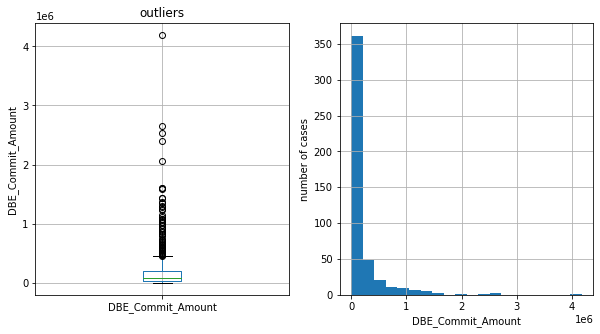

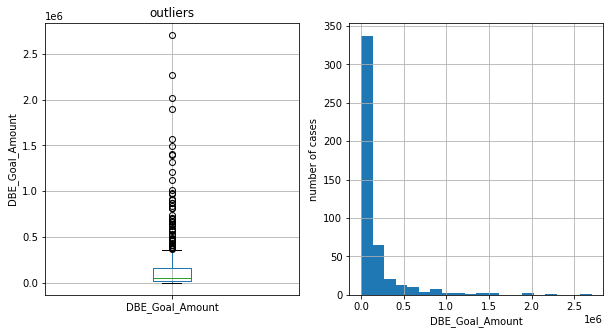

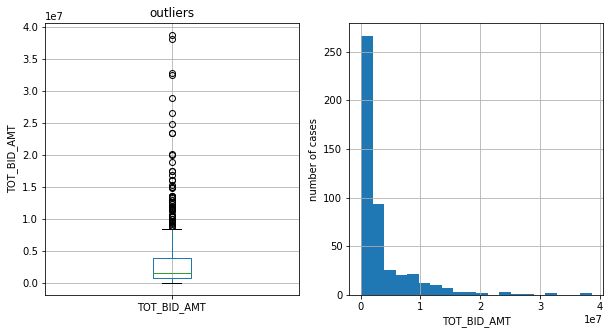

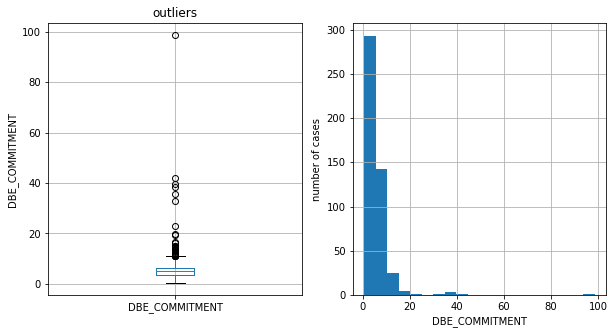

In [35]:
for var in continuous:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    fig = data.boxplot(column=var)
    fig.set_title('outliers')
    fig.set_ylabel(var)
    
    plt.subplot(1,2,2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('number of cases')
    fig.set_xlabel(var)    
    plt.show()

In [36]:
def diagnostic_plot(df, variable):
    plt.figure(figsize=(16, 4))
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

In [37]:
data_copy = data.copy()
data_copy['DBE_Commit_Amount'].skew(skipna = True)
data_copy['DBE_Commit_Amount_log'] = data_copy['DBE_Commit_Amount'].map(lambda x: np.log(x))
data_copy['DBE_Commit_Amount_rec'] = data_copy['DBE_Commit_Amount'].map(lambda x: np.reciprocal(x))
data_copy['DBE_Commit_Amount_sqrt'] = data_copy['DBE_Commit_Amount'].map(lambda x: np.sqrt(x))

In [38]:
data_copy['DBE_Commit_Amount'].skew(skipna = True)

4.5262232161389875

In [39]:
data_copy['DBE_Commit_Amount_log'].skew(skipna = True)

0.32163240780163027

In [40]:
data_copy['DBE_Commit_Amount_rec'].skew(skipna = True)

15.19408354323122

In [41]:
data_copy['DBE_Commit_Amount_sqrt'].skew(skipna = True)

2.0289023141084765

In [42]:
data['DBE_Commit_Amount_log'] = data['DBE_Commit_Amount'].map(lambda x: np.log(x))

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


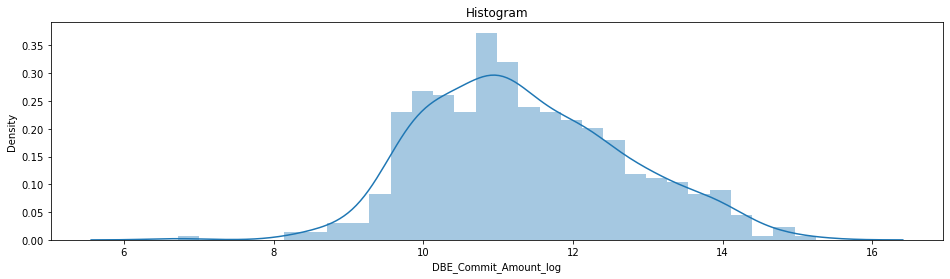

In [43]:
diagnostic_plot(data_copy, 'DBE_Commit_Amount_log')

In [44]:
data_copy['DBE_Goal_Amount'].skew(skipna = True)

4.157202320469541

In [45]:
data_copy['DBE_Goal_Amount_log'] = data_copy['DBE_Goal_Amount'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['DBE_Goal_Amount_rec'] = data_copy['DBE_Goal_Amount'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['DBE_Goal_Amount_sqrt'] = data_copy['DBE_Goal_Amount'].map(lambda x: np.sqrt(x))

In [46]:
data_copy['DBE_Goal_Amount_log'].skew(skipna = True)

0.2721681232692274

In [47]:
data_copy['DBE_Goal_Amount_rec'].skew(skipna = True)

9.983727501697622

In [48]:
data_copy['DBE_Goal_Amount_sqrt'].skew(skipna = True)

2.017816736547592

In [49]:
data['DBE_Goal_Amount_log'] = data['DBE_Goal_Amount'].map(lambda x: np.log(x) if x > 0 else 0)

In [50]:
data.drop(['DBE_Commit_Amount'], axis=1, inplace=True)

In [51]:
data.drop(['DBE_Goal_Amount'], axis=1, inplace=True)

In [52]:
data.shape

(472, 10)

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


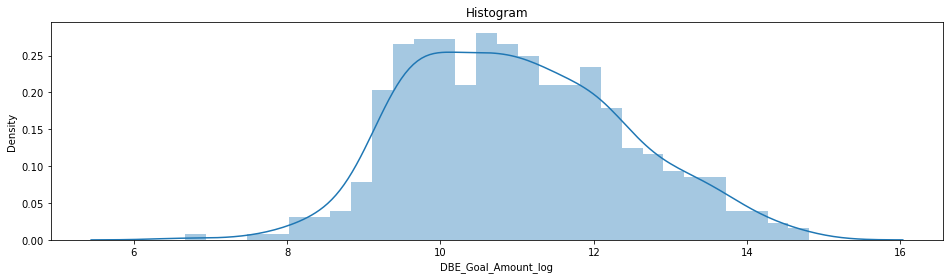

In [53]:
diagnostic_plot(data_copy, 'DBE_Goal_Amount_log')

In [54]:
data_copy['TOT_BID_AMT_log'] = data_copy['TOT_BID_AMT'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['TOT_BID_AMT_rec'] = data_copy['TOT_BID_AMT'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['TOT_BID_AMT_sqrt'] = data_copy['TOT_BID_AMT'].map(lambda x: np.sqrt(x))

In [55]:
data_copy['TOT_BID_AMT_log'].skew(skipna = True)

0.31891454423796706

In [56]:
data_copy['TOT_BID_AMT_rec'].skew(skipna = True)

0.0

In [57]:
data_copy['TOT_BID_AMT_sqrt'].skew(skipna = True)

1.6287363552136287

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


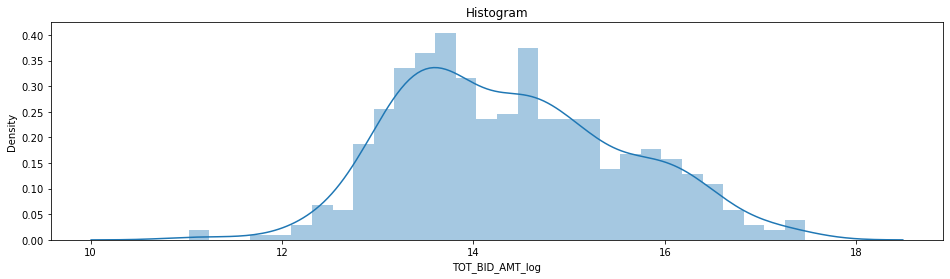

In [58]:
diagnostic_plot(data_copy, 'TOT_BID_AMT_log')

In [59]:
data['TOT_BID_AMT_log'] = data['TOT_BID_AMT'].map(lambda x: np.log(x) if x > 0 else 0)

In [60]:
data.drop(['TOT_BID_AMT'], axis=1, inplace=True)

In [61]:
data.shape

(472, 10)

In [62]:
data_copy['DBE_COMMITMENT'].skew(skipna = True)

8.901630749149783

In [63]:
data_copy['DBE_COMMITMENT_log'] = data_copy['DBE_COMMITMENT'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['DBE_COMMITMENT_rec'] = data_copy['DBE_COMMITMENT'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['DBE_COMMITMENT_sqrt'] = data_copy['DBE_COMMITMENT'].map(lambda x: np.sqrt(x))

In [64]:
data_copy['DBE_COMMITMENT_log'].skew(skipna = True)

0.4197024487103917

In [65]:
data_copy['DBE_COMMITMENT_rec'].skew(skipna = True)

4.295712923406511

In [66]:
data_copy['DBE_COMMITMENT_sqrt'].skew(skipna = True)

3.360574621393756

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


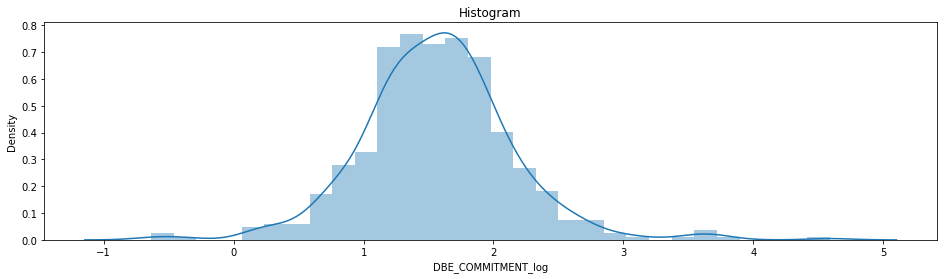

In [67]:
diagnostic_plot(data_copy, 'DBE_COMMITMENT_log')

In [68]:
data['DBE_COMMITMENT_log'] = data['DBE_COMMITMENT'].map(lambda x: np.log(x) if x > 0 else 0)

In [69]:
data.drop(['DBE_COMMITMENT'], axis=1, inplace=True)

In [70]:
data.shape

(472, 10)

In [71]:
def find_boundaries(df, variable):
# calculate the boundaries anything outside the upper and lower boundaries is an outlier
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()
    return upper_boundary, lower_boundary

In [72]:
upper_boundary, lower_boundary = find_boundaries(data, 'DBE_Commit_Amount_log')
upper_boundary, lower_boundary

(15.327041338696588, 7.382578643304168)

In [73]:
print('We have {} upper boundary outliers:'.format(len(data[data['DBE_Commit_Amount_log'] > upper_boundary])))
print('We have {} lower boundary outliers:'.format(len(data[data['DBE_Commit_Amount_log'] < lower_boundary])))

We have 0 upper boundary outliers:
We have 1 lower boundary outliers:


In [74]:
upper_boundary2, lower_boundary2 = find_boundaries(data, 'DBE_Goal_Amount_log')
upper_boundary2, lower_boundary2

(15.180316166147982, 6.814481470787463)

In [75]:
print('We have {} upper boundary outliers:'.format(len(data[data['DBE_Goal_Amount_log'] > upper_boundary2])))
print('We have {} lower boundary outliers:'.format(len(data[data['DBE_Goal_Amount_log'] < lower_boundary2])))

We have 0 upper boundary outliers:
We have 1 lower boundary outliers:


In [76]:
upper_boundary3, lower_boundary3 = find_boundaries(data, 'TOT_BID_AMT_log')
upper_boundary3, lower_boundary3

(17.882782470634407, 10.900325185089823)

In [77]:
print('We have {} upper boundary outliers:'.format(len(data[data['TOT_BID_AMT_log'] > upper_boundary3])))
print('We have {} lower boundary outliers:'.format(len(data[data['TOT_BID_AMT_log'] < lower_boundary3])))

We have 0 upper boundary outliers:
We have 0 lower boundary outliers:


In [78]:
upper_boundary4, lower_boundary4 = find_boundaries(data, 'DBE_COMMITMENT_log')
upper_boundary4, lower_boundary4

(3.319543721617266, -0.1826910233645591)

In [79]:
print('We have {} upper boundary outliers:'.format(len(data[data['DBE_COMMITMENT_log'] > upper_boundary4])))
print('We have {} lower boundary outliers:'.format(len(data[data['DBE_COMMITMENT_log'] < lower_boundary4])))

We have 6 upper boundary outliers:
We have 3 lower boundary outliers:


In [80]:
data['DBE_goal'].value_counts()

1    429
0     43
Name: DBE_goal, dtype: int64

In [81]:
# Identify the outliers 
outliers_DBE_Commit_Amount = np.where(data['DBE_Commit_Amount_log'] > upper_boundary, True, np.where(data['DBE_Commit_Amount_log'] < lower_boundary, True, False))
# trim the df of the outliers
data = data.loc[~(outliers_DBE_Commit_Amount)]

In [82]:
outliers_DBE_Goal_Amount = np.where(data['DBE_Goal_Amount_log'] > upper_boundary2, True, np.where(data['DBE_Goal_Amount_log'] < lower_boundary2, True, False))
data = data.loc[~(outliers_DBE_Goal_Amount)]

In [83]:
outliers_TOT_BID_AMT = np.where(data['TOT_BID_AMT_log'] > upper_boundary3, True, np.where(data['TOT_BID_AMT_log'] < lower_boundary3, True, False))
data = data.loc[~(outliers_TOT_BID_AMT)]

In [84]:
outliers_DBE_COMMITMENT = np.where(data['DBE_COMMITMENT_log'] > upper_boundary4, True, np.where(data['DBE_COMMITMENT_log'] < lower_boundary4, True, False))
data = data.loc[~(outliers_DBE_COMMITMENT)]

In [85]:
data.shape

(463, 10)

In [86]:
data['DBE_goal'].value_counts()

1    422
0     41
Name: DBE_goal, dtype: int64

In [87]:
data[discrete] = data[discrete].astype('O')
data['DBE_goal'] = data['DBE_goal'].astype('O')

In [88]:
data.dtypes

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT            object
BID_DAYS                  object
DBE_goal                  object
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
dtype: object

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('DBE_goal', axis=1),
    data['DBE_goal'],
    test_size=0.3,
    random_state=SEED)

In [90]:
data.dtypes
#categorical = ['PRIME_VEND_ID', 'FUND_IND', 'FUNDTYPE', 'PROPOSAL_TYPE','DBE_goal']
#discrete = ['DBEGOALPERCENT','BID_DAYS']
#continuous = ['DBE_Commit_Amount', 'DBE_Goal_Amount','TOT_BID_AMT','DBE_COMMITMENT']

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT            object
BID_DAYS                  object
DBE_goal                  object
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
dtype: object

In [91]:
feat_transform = pipe([
# Encoding rare categories for categorical and discrete features (Less than 1% is rare)
('rare_label_encoder', RareLabelEncoder(
tol=0.05, n_categories=6, variables=['BID_DAYS','FUNDTYPE','PROPOSAL_TYPE','DBEGOALPERCENT']
)),
# We will use one_hot_encoding for categorical features
('one_hot_categorical_encoder', OneHotEncoder(variables=['BID_DAYS','FUND_IND','FUNDTYPE','PROPOSAL_TYPE','DBEGOALPERCENT'],drop_last=True))
# We are going to use ordinal encoding according to the target mean to the target feature
#('ordinal_categorical_encoder', OrdinalEncoder(encoding_method='ordered',variables=['DBEGOALPERCENT','BID_DAYS']))
])

In [92]:
X_train.dtypes

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT            object
BID_DAYS                  object
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
dtype: object

In [93]:
feat_transform.fit(X_train, y_train)
X_train_clean = feat_transform.transform(X_train)
X_test_clean = feat_transform.transform(X_test)
X_train_clean.head()


,DBE_Commit_Amount_log,DBE_Goal_Amount_log,TOT_BID_AMT_log,DBE_COMMITMENT_log,BID_DAYS_Rare,BID_DAYS_90.0,BID_DAYS_120.0,BID_DAYS_60.0,FUND_IND_B,FUNDTYPE_0FED,PROPOSAL_TYPE_Rare,"PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE",PROPOSAL_TYPE_BRIDGE AND APPROACHES,PROPOSAL_TYPE_BRIDGE REHABILITATION,"PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE",DBEGOALPERCENT_Rare,DBEGOALPERCENT_2.0,DBEGOALPERCENT_6.0,DBEGOALPERCENT_3.0,DBEGOALPERCENT_4.0
8,11.473424,11.441925,15.130805,0.947789,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0
429,13.266546,11.723247,15.635270,2.236445,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0
110,10.672401,10.667413,13.480824,1.796747,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0
241,12.297250,12.163302,15.669860,1.232560,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0
441,10.246217,10.033124,13.252000,1.599388,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1


In [94]:
X_train_clean.shape

(324, 20)

In [95]:
X_test_clean.shape

(139, 20)

In [96]:
scaler = StandardScaler()
scaler.fit(X_train_clean)
X_train_std = scaler.transform(X_train_clean)
X_test_std = scaler.transform(X_test_clean)

In [97]:
X_train_clean.head(4)

,DBE_Commit_Amount_log,DBE_Goal_Amount_log,TOT_BID_AMT_log,DBE_COMMITMENT_log,BID_DAYS_Rare,BID_DAYS_90.0,BID_DAYS_120.0,BID_DAYS_60.0,FUND_IND_B,FUNDTYPE_0FED,PROPOSAL_TYPE_Rare,"PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE",PROPOSAL_TYPE_BRIDGE AND APPROACHES,PROPOSAL_TYPE_BRIDGE REHABILITATION,"PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE",DBEGOALPERCENT_Rare,DBEGOALPERCENT_2.0,DBEGOALPERCENT_6.0,DBEGOALPERCENT_3.0,DBEGOALPERCENT_4.0
8,11.473424,11.441925,15.130805,0.947789,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0
429,13.266546,11.723247,15.635270,2.236445,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0
110,10.672401,10.667413,13.480824,1.796747,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0
241,12.297250,12.163302,15.669860,1.232560,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0


In [100]:
col_names = ['DBE_Commit_Amount_log','DBE_Goal_Amount_log','TOT_BID_AMT_log','DBE_COMMITMENT_log','BID_DAYS_Rare','BID_DAYS_90.0','BID_DAYS_120.0','BID_DAYS_60.0','FUND_IND_B','FUNDTYPE_0FED','PROPOSAL_TYPE_Rare','PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE','PROPOSAL_TYPE_BRIDGE AND APPROACHES','PROPOSAL_TYPE_BRIDGE REHABILITATION','PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE','DBEGOALPERCENT_Rare','DBEGOALPERCENT_2.0','DBEGOALPERCENT_6.0','DBEGOALPERCENT_3.0','DBEGOALPERCENT_4.0']

In [101]:
X_train_std_df = pd.DataFrame(X_train_std, columns=col_names)
X_test_std_df = pd.DataFrame(X_test_std, columns=col_names)

In [102]:
X_train_std_df.head()

,DBE_Commit_Amount_log,DBE_Goal_Amount_log,TOT_BID_AMT_log,DBE_COMMITMENT_log,BID_DAYS_Rare,BID_DAYS_90.0,BID_DAYS_120.0,BID_DAYS_60.0,FUND_IND_B,FUNDTYPE_0FED,PROPOSAL_TYPE_Rare,"PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE",PROPOSAL_TYPE_BRIDGE AND APPROACHES,PROPOSAL_TYPE_BRIDGE REHABILITATION,"PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE",DBEGOALPERCENT_Rare,DBEGOALPERCENT_2.0,DBEGOALPERCENT_6.0,DBEGOALPERCENT_3.0,DBEGOALPERCENT_4.0
0,0.070589,0.286193,0.582786,-1.199756,0.855932,-0.369922,-0.462042,-0.24959,0.620174,0.364509,2.141543,-0.289157,-0.981650,-0.235318,-0.295378,1.940285,-0.471849,-0.353553,-0.496139,-0.462042
1,1.457630,0.485743,1.003422,1.344489,0.855932,-0.369922,-0.462042,-0.24959,0.620174,0.364509,-0.466953,3.458323,-0.981650,-0.235318,-0.295378,-0.515388,2.119322,-0.353553,-0.496139,-0.462042
2,-0.549029,-0.263190,-0.793010,0.476375,-1.168317,2.703274,-0.462042,-0.24959,0.620174,0.364509,-0.466953,3.458323,-0.981650,-0.235318,-0.295378,-0.515388,-0.471849,2.828427,-0.496139,-0.462042
3,0.707847,0.797886,1.032264,-0.637522,0.855932,-0.369922,-0.462042,-0.24959,0.620174,0.364509,2.141543,-0.289157,-0.981650,-0.235318,-0.295378,-0.515388,-0.471849,-0.353553,2.015564,-0.462042
4,-0.878697,-0.713109,-0.983810,0.086720,-1.168317,-0.369922,2.164304,-0.24959,0.620174,0.364509,-0.466953,-0.289157,1.018693,-0.235318,-0.295378,-0.515388,-0.471849,-0.353553,-0.496139,2.164304


In [103]:
X_train_std_df.shape

(324, 20)

In [104]:
X_train_std_df.dtypes

DBE_Commit_Amount_log                              float64
DBE_Goal_Amount_log                                float64
TOT_BID_AMT_log                                    float64
DBE_COMMITMENT_log                                 float64
BID_DAYS_Rare                                      float64
BID_DAYS_90.0                                      float64
BID_DAYS_120.0                                     float64
BID_DAYS_60.0                                      float64
FUND_IND_B                                         float64
FUNDTYPE_0FED                                      float64
PROPOSAL_TYPE_Rare                                 float64
PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE            float64
PROPOSAL_TYPE_BRIDGE AND APPROACHES                float64
PROPOSAL_TYPE_BRIDGE REHABILITATION                float64
PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE    float64
DBEGOALPERCENT_Rare                                float64
DBEGOALPERCENT_2.0                                 float

In [105]:
y_train=y_train.astype('int')

In [106]:
y_train.value_counts()

1    298
0     26
Name: DBE_goal, dtype: int64

In [107]:
y_test=y_test.astype('int')

In [108]:
y_test.value_counts()

1    124
0     15
Name: DBE_goal, dtype: int64

[0.76       0.79666667 0.66333333 0.75141243 0.79661017]
Logistic Regression: Avg CV roc_auc using all features on training data: 0.7536
Logistic Regression: roc_auc w/all features on test data 1.0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.89      1.00      0.94       124

    accuracy                           0.89       139
   macro avg       0.45      0.50      0.47       139
weighted avg       0.80      0.89      0.84       139

[[  0  15]
 [  0 124]]


C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


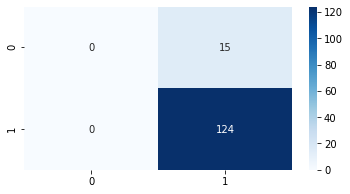

-------------------------------------------------------
[0.76833333 0.88       0.87833333 0.63559322 0.88813559]
Random Forest: Avg CV roc_auc using all features on training data: 0.8101
Random Forest: roc_auc w/all features on test data 1.0:
              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.90      1.00      0.95       124

    accuracy                           0.90       139
   macro avg       0.95      0.53      0.54       139
weighted avg       0.91      0.90      0.86       139

[[  1  14]
 [  0 124]]


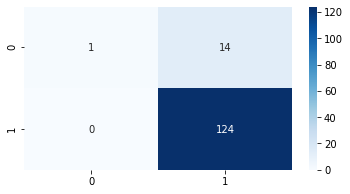

-------------------------------------------------------
[0.80333333 0.83       0.79       0.72881356 0.82711864]
Naive Bayes: Avg CV roc_auc using all features on training data: 0.7959
Naive Bayes: roc_auc w/all features on test data 0.2581:
              precision    recall  f1-score   support

           0       0.12      0.87      0.22        15
           1       0.94      0.26      0.41       124

    accuracy                           0.32       139
   macro avg       0.53      0.56      0.31       139
weighted avg       0.85      0.32      0.38       139

[[13  2]
 [92 32]]


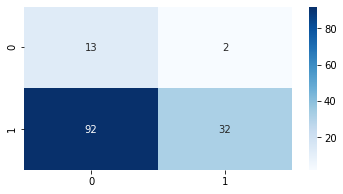

-------------------------------------------------------
[0.66666667 0.87       0.79       0.52542373 0.89830508]
Gradient Boosting Classifier: Avg CV roc_auc using all features on training data: 0.7501
Gradient Boosting Classifier: roc_auc w/all features on test data 0.9677:
              precision    recall  f1-score   support

           0       0.20      0.07      0.10        15
           1       0.90      0.97      0.93       124

    accuracy                           0.87       139
   macro avg       0.55      0.52      0.52       139
weighted avg       0.82      0.87      0.84       139

[[  1  14]
 [  4 120]]


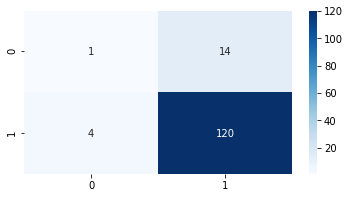

-------------------------------------------------------
[0.41666667 0.66666667 0.66666667 0.54096045 0.66610169]
Decision Tree: Avg CV roc_auc using all features on training data: 0.5914
Decision Tree: roc_auc w/all features on test data 0.9274:
              precision    recall  f1-score   support

           0       0.18      0.13      0.15        15
           1       0.90      0.93      0.91       124

    accuracy                           0.84       139
   macro avg       0.54      0.53      0.53       139
weighted avg       0.82      0.84      0.83       139

[[  2  13]
 [  9 115]]


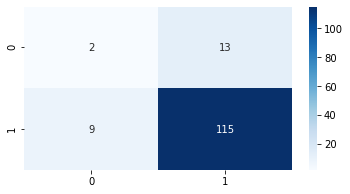

-------------------------------------------------------
[0.74       0.76       0.68666667 0.63841808 0.47118644]
Support Vector Machine: Avg CV roc_auc using all features on training data: 0.6593
Support Vector Machine: roc_auc w/all features on test data 1.0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.89      1.00      0.94       124

    accuracy                           0.89       139
   macro avg       0.45      0.50      0.47       139
weighted avg       0.80      0.89      0.84       139

[[  0  15]
 [  0 124]]


C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


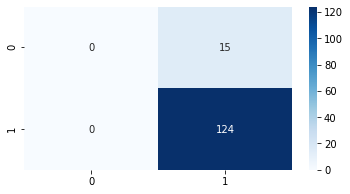

-------------------------------------------------------
[0.74666667 0.705      0.66166667 0.51412429 0.67627119]
Nearest Neighbors: Avg CV roc_auc using all features on training data: 0.6607
Nearest Neighbors: roc_auc w/all features on test data 1.0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.89      1.00      0.94       124

    accuracy                           0.89       139
   macro avg       0.45      0.50      0.47       139
weighted avg       0.80      0.89      0.84       139

[[  0  15]
 [  0 124]]


C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


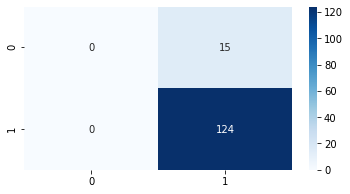

-------------------------------------------------------
[0.72       0.90333333 0.84       0.66101695 0.71186441]
Neural Net: Avg CV roc_auc using all features on training data: 0.7672
Neural Net: roc_auc w/all features on test data 0.9677:
              precision    recall  f1-score   support

           0       0.20      0.07      0.10        15
           1       0.90      0.97      0.93       124

    accuracy                           0.87       139
   macro avg       0.55      0.52      0.52       139
weighted avg       0.82      0.87      0.84       139

[[  1  14]
 [  4 120]]


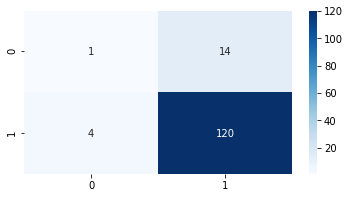

-------------------------------------------------------


In [109]:
models = []
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', solver='saga',max_iter=10000, random_state=42)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100,random_state=42)))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Support Vector Machine', svm.SVC(gamma = 'auto')))
models.append(('Nearest Neighbors', KNeighborsClassifier()))
models.append(('Neural Net',  MLPClassifier(solver='adam', alpha=0.0001,learning_rate='constant',max_iter=2000, learning_rate_init=0.001,random_state=42)))
base_model_train = []
base_model_test = []
for name, classifier in models:
    scores = cross_val_score(classifier, X_train_std_df, y_train, cv=5, scoring='roc_auc')
    base_model_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV roc_auc using all features on training data: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_df, y_train)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    base_model_test.append(test_recall.round(4))
    print('{}: roc_auc w/all features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    plt.figure(figsize=(6,3))
    sns.heatmap(cnf_matrix, annot=True,cmap='Blues', fmt='g')
    plt.show()
    print('-------------------------------------------------------')

[0.76333333 0.84333333 0.65666667 0.71186441 0.76949153]
Logistic Regression: Avg CV roc_auc w/All Reatures: 0.7489
Logistic Regression: roc_auc w/All Features on test data 0.8226:
              precision    recall  f1-score   support

           0       0.19      0.33      0.24        15
           1       0.91      0.82      0.86       124

    accuracy                           0.77       139
   macro avg       0.55      0.58      0.55       139
weighted avg       0.83      0.77      0.80       139

[[  5  10]
 [ 22 102]]


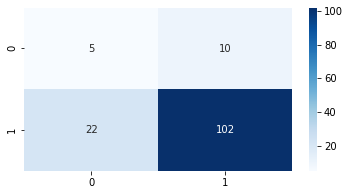

-------------------------------------------------------
[0.74833333 0.84166667 0.85833333 0.66384181 0.77966102]
Random Forest: Avg CV roc_auc w/All Reatures: 0.7784
Random Forest: roc_auc w/All Features on test data 0.9758:
              precision    recall  f1-score   support

           0       0.40      0.13      0.20        15
           1       0.90      0.98      0.94       124

    accuracy                           0.88       139
   macro avg       0.65      0.55      0.57       139
weighted avg       0.85      0.88      0.86       139

[[  2  13]
 [  3 121]]


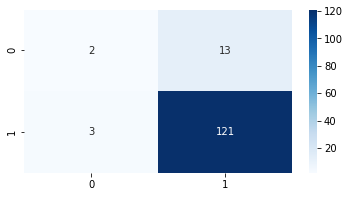

-------------------------------------------------------
[0.785      0.83       0.80333333 0.68079096 0.82033898]
Naive Bayes: Avg CV roc_auc w/All Reatures: 0.7839
Naive Bayes: roc_auc w/All Features on test data 0.3226:
              precision    recall  f1-score   support

           0       0.12      0.80      0.22        15
           1       0.93      0.32      0.48       124

    accuracy                           0.37       139
   macro avg       0.53      0.56      0.35       139
weighted avg       0.84      0.37      0.45       139

[[12  3]
 [84 40]]


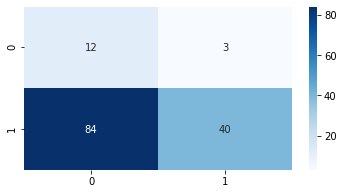

-------------------------------------------------------
[0.71       0.87666667 0.77       0.64265537 0.70847458]
Gradient Boosting Classifier: Avg CV roc_auc w/All Reatures: 0.7416
Gradient Boosting Classifier: roc_auc w/All Features on test data 0.9516:
              precision    recall  f1-score   support

           0       0.25      0.13      0.17        15
           1       0.90      0.95      0.93       124

    accuracy                           0.86       139
   macro avg       0.58      0.54      0.55       139
weighted avg       0.83      0.86      0.84       139

[[  2  13]
 [  6 118]]


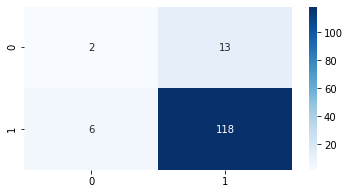

-------------------------------------------------------
[0.64166667 0.56666667 0.56666667 0.74858757 0.62372881]
Decision Tree: Avg CV roc_auc w/All Reatures: 0.6295
Decision Tree: roc_auc w/All Features on test data 0.9355:
              precision    recall  f1-score   support

           0       0.20      0.13      0.16        15
           1       0.90      0.94      0.92       124

    accuracy                           0.85       139
   macro avg       0.55      0.53      0.54       139
weighted avg       0.82      0.85      0.84       139

[[  2  13]
 [  8 116]]


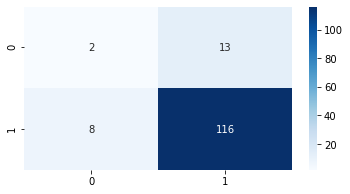

-------------------------------------------------------
[0.71       0.88       0.77333333 0.66101695 0.77288136]
Support Vector Machine: Avg CV roc_auc w/All Reatures: 0.7594
Support Vector Machine: roc_auc w/All Features on test data 0.9032:
              precision    recall  f1-score   support

           0       0.14      0.13      0.14        15
           1       0.90      0.90      0.90       124

    accuracy                           0.82       139
   macro avg       0.52      0.52      0.52       139
weighted avg       0.81      0.82      0.82       139

[[  2  13]
 [ 12 112]]


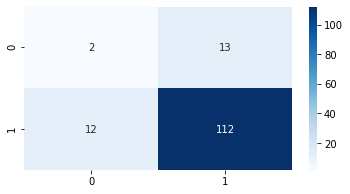

-------------------------------------------------------
[0.685      0.80833333 0.69833333 0.49858757 0.56949153]
Nearest Neighbors: Avg CV roc_auc w/All Reatures: 0.6519
Nearest Neighbors: roc_auc w/All Features on test data 0.8629:
              precision    recall  f1-score   support

           0       0.15      0.20      0.17        15
           1       0.90      0.86      0.88       124

    accuracy                           0.79       139
   macro avg       0.52      0.53      0.53       139
weighted avg       0.82      0.79      0.80       139

[[  3  12]
 [ 17 107]]


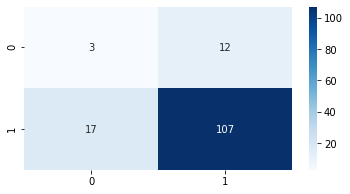

-------------------------------------------------------
[0.70666667 0.89       0.82333333 0.60734463 0.64745763]
Neural Net: Avg CV roc_auc w/All Reatures: 0.735
Neural Net: roc_auc w/All Features on test data 0.9355:
              precision    recall  f1-score   support

           0       0.11      0.07      0.08        15
           1       0.89      0.94      0.91       124

    accuracy                           0.84       139
   macro avg       0.50      0.50      0.50       139
weighted avg       0.81      0.84      0.82       139

[[  1  14]
 [  8 116]]


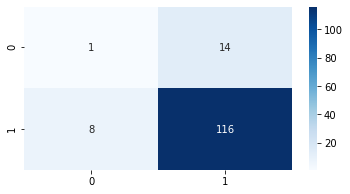

-------------------------------------------------------


In [110]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_std_sm, y_train_sm = sm.fit_resample(X_train_std_df, y_train)
model1_train = []
model1_test = []
for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_val_score(pipeline, X_train_std_df, y_train, cv=5, scoring='roc_auc')
    model1_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV roc_auc w/All Reatures: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_sm, y_train_sm)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds)
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model1_test.append(test_recall.round(4))
    print('{}: roc_auc w/All Features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    plt.figure(figsize=(6,3))
    sns.heatmap(cnf_matrix, annot=True,cmap='Blues', fmt='g')
    plt.show()
    print('-------------------------------------------------------')

In [111]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_selector.fit(X_train_std_sm, y_train_sm)
feature_imp = pd.Series(rf_selector.feature_importances_, index=X_train_std_df.columns).sort_values(ascending=False)
#feature_imp[:30]

In [112]:
feature_imp

DBE_Commit_Amount_log                              0.154154
TOT_BID_AMT_log                                    0.145946
DBE_COMMITMENT_log                                 0.132313
DBE_Goal_Amount_log                                0.127912
DBEGOALPERCENT_4.0                                 0.065896
DBEGOALPERCENT_2.0                                 0.060655
BID_DAYS_Rare                                      0.049874
PROPOSAL_TYPE_BRIDGE AND APPROACHES                0.048249
BID_DAYS_120.0                                     0.039214
DBEGOALPERCENT_Rare                                0.031147
FUNDTYPE_0FED                                      0.026449
PROPOSAL_TYPE_Rare                                 0.020398
DBEGOALPERCENT_3.0                                 0.019864
FUND_IND_B                                         0.019808
BID_DAYS_90.0                                      0.019591
PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE            0.014923
BID_DAYS_60.0                           

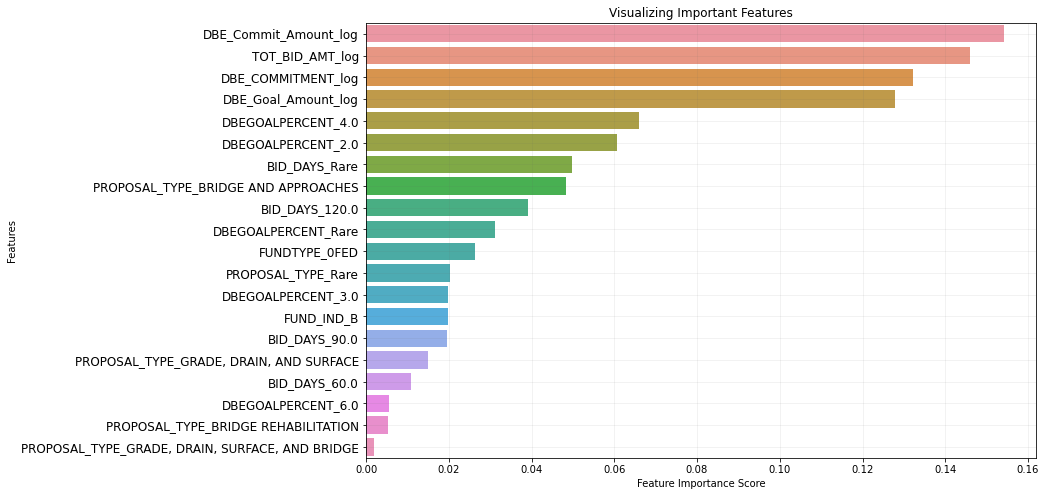

In [113]:
X_train_rf = X_train_std_df[feature_imp.index]
X_test_rf = X_test_std_df[feature_imp.index]
plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp[0:30], y=feature_imp.index[0:30])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.yticks(fontsize=12)
plt.grid(which='major', color='#666666', linestyle='-', alpha=0.1)
plt.show()

In [114]:
clf_lr = LogisticRegression(solver='saga',max_iter=10000, random_state=SEED)
penalty = ['l1','l2']
C = [0.001,0.002,0.003,0.005,1,10,100,1000]
skf = StratifiedKFold(n_splits=5)
pipeline = make_pipeline(sm, clf_lr)
param_grid = dict(logisticregression__penalty=penalty,
                  logisticregression__C=C)
grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='roc_auc', 
                    verbose=1, cv=skf)
grid_results = grid.fit(X_train_std_sm, y_train_sm) 
print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.865406779661017
Best Params:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l1'}
